In [1]:

# some utility modules and functions
from geographiclib.geodesic import Geodesic
geod = Geodesic.WGS84

import matplotlib as mpl
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import os
import pandas as pd

from pyrocko import moment_tensor as pmt
from pyrocko.plot import beachball

from scipy.interpolate import griddata

# load model parameters from `fort.40` and store the values as pandas data frame
def load_fort40(infile):
    col_names = [ 'c{0:02d}'.format(i) for i in range(10)]
    df = pd.read_table(infile, names=col_names, header=None, delimiter='\t')
    tmp1 = [ float(x) for x in df['c00'][1].replace(' ', ',').split(',') if x ]
    tmp3 = [ float(x) for x in df['c00'][3].replace(' ', ',').split(',') if x ]
    tmp5 = [ float(x) for x in df['c00'][5].replace(' ', ',').split(',') if x ]
    tmp7 = [ float(x) for x in df['c00'][7].replace(' ', ',').split(',') if x ]
    df = pd.DataFrame({ 'moment'   : tmp1[0],
                        'mw'       : tmp1[1],
                        'rigidity' : tmp1[2],
                        'lat'      : tmp1[3],
                        'lon'      : tmp1[4],
                        'depth'    : tmp1[5],
                        'vr'       : tmp1[6],
                        'nsurface' : tmp1[7],

                        'strike'   : tmp3[0],
                        'dip'      : tmp3[1],

                        'xx'       : tmp5[0],
                        'yy'       : tmp5[1],
                        'mn'       : int(tmp5[2]),
                        'nn'       : int(tmp5[3]),
                        'm0'       : int(tmp5[4]),
                        'n0'       : int(tmp5[5]),
                        'tr'       : tmp5[6],
                        'jtn'      : int(tmp5[7]),
                        'icmn'     : int(tmp5[8]),

                        'variance' : tmp7[0],

                      }, index=[0])
    return df

# select a preferred fault plane
def selectplane(modelstk, modeldip, stk0, dip0, rake0, stk1, dip1, rake1):
    vecmodelplane = faultnormalvec(modelstk, modeldip)
    vecplane0 = faultnormalvec(stk0, dip0)
    vecplane1 = faultnormalvec(stk1, dip1)
    tmp0 = np.inner(vecmodelplane, vecplane0)
    tmp1 = np.inner(vecmodelplane, vecplane1)
    if abs(tmp0) > abs(tmp1):
        stk_s = stk0
        dip_s = dip0
        rake_s = rake0
    elif abs(tmp0) < abs(tmp1):
        stk_s = stk1
        dip_s = dip1
        rake_s = rake1
    else:
        stk_s = stk0
        dip_s = dip0
        rake_s = rake0
    return stk_s, dip_s, rake_s

# define a fault-normal vector
def faultnormalvec(stk, dip):
    nn = -np.sin(np.deg2rad(stk)) * np.sin(np.deg2rad(dip))
    ne =  np.cos(np.deg2rad(stk)) * np.sin(np.deg2rad(dip))
    nd = -np.cos(np.deg2rad(dip))
    return np.array([ne, nn, nd])


# a storage path 
datarootdir = './'

# unique model ids
# - initial Mw 7.9 event
modelid_initial = 'results_20230223-082902'

# - alternative models
# -  initial Mw 7.9 event: using ak135 model for near-source velocity structure
# modelid_initial = results_20230501-234704

# -  initial Mw 7.9 event: max Vr = 5.0 km/s
# modelid_initial = results_20230224-112444

# -  initial Mw 7.9 event: shorter duration of basis potency-rate functions
# modelid_initial = results_20230430-221457

# -  initial Mw 7.9 event: constrained to be only strike-slip
# modelid_initial = results_20230427-110701

# - secondary Mw 7.6 event
modelid_second = 'results_20230215-052238'

-430.0 -30.0 -40.0 40.0 -15.0 15.0


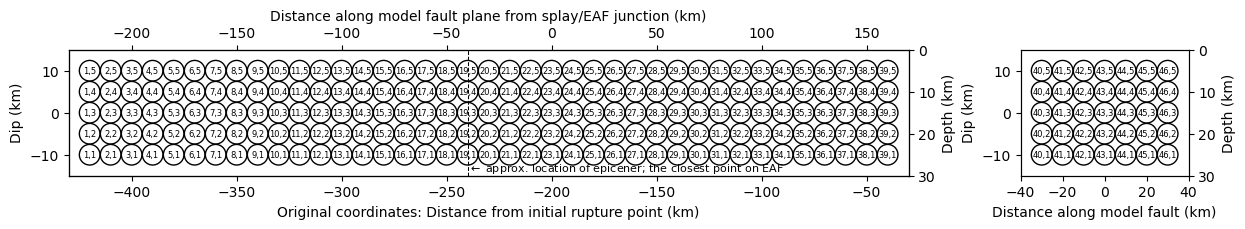

In [2]:
modelid = modelid_initial
model_para = load_fort40(os.path.join(datarootdir,modelid,'const','fort.40'))

# some important indexes of source elements
m1 = 39 # right end of main EAF
m2 = 23 # (near) junction of EAF and splay faults
x_for_m2 = (m2-model_para.m0[0])*model_para.xx[0] # location of junction on the original coordinates

# define axes edges; add margin ±10 km from the edge element
xmin_main=(1-model_para.m0[0])*model_para.xx[0]-model_para.xx[0]
xmax_main=(m1-model_para.m0[0])*model_para.xx[0]+model_para.xx[0]
xmin_branch=(m1+1-model_para.m0[0])*model_para.xx[0]-model_para.xx[0]
xmax_branch=(model_para.mn[0]-model_para.m0[0])*model_para.xx[0]+model_para.xx[0]
ymin=(1-model_para.n0[0])*model_para.yy[0]-model_para.yy[0]
ymax=(model_para.nn[0]-model_para.n0[0])*model_para.yy[0]+model_para.yy[0]
ymin_branch,ymax_branch=ymin,ymax
print(xmin_main,xmax_main,xmin_branch,xmax_branch,ymin,ymax)

fig=plt.figure(figsize=(5.6,5.6))

# main EAF axis
axx,axy=0.1,0.1
axw=1.5
aspect=abs(ymax-ymin)/abs(xmax_main-xmin_main)
axh=axw*aspect*2
ax1=fig.add_axes([axx,axy,axw,axh])
ax1.set(xlim=[xmin_main,xmax_main],ylim=[ymin,ymax],ylabel='Dip (km)',xlabel='Original coordinates: Distance from initial rupture point (km)')
# plot a line indicating the point on the EAF, which is the closest to the initial rupture point on the splay fault, regarded as an approximimate location of epicenter
ax1.axvline(x_for_m2-40,lw=0.75,linestyle='--',color='k',zorder=11)
ax1.text(x_for_m2-40,ymin,r'$\leftarrow$'+' approx. location of epicener; the closest point on EAF',ha='left',va='bottom',size=8)

# location of junction on the main EAF
x_for_m2 = (m2-model_para.m0[0])*model_para.xx[0]

# add psuedo axis, just shift the distance by measuring from the splay/EAF junction
ax = ax1.twiny()
ax.set(xlim=[xmin_main-x_for_m2,xmax_main-x_for_m2],xlabel='Distance along model fault plane from splay/EAF junction (km)')

# splay fault axis
axp=ax1.get_position()
axx,axy=axp.x1+0.2,axp.y0
axw=axw*(abs(xmax_branch-xmin_branch)/abs(xmax_main-xmin_main))
axh=axp.height
ax2=fig.add_axes([axx,axy,axw,axh])
ax2.set(xlim=[xmin_branch,xmax_branch],ylim=[ymin,ymax],xlabel='Distance along model fault (km)',ylabel='Dip (km)')

# add depth axis
for ax in [ax1,ax2]:
    ax_dep = ax.twinx()
    depmin = model_para.depth[0]-np.sin(np.deg2rad(model_para.dip[0]))*ymin
    depmax = model_para.depth[0]-np.sin(np.deg2rad(model_para.dip[0]))*ymax
    ax_dep.set(ylim=[depmin, depmax],ylabel='Depth (km)')

col_names = ['k','l','lat','lon','dep','strike','dip','rake','xloc','yloc']
df_knot = pd.read_table(os.path.join(datarootdir, modelid, 'const/knot.dat_in'), names=col_names, header=None,
                   delim_whitespace=True)
col_names = ['ylocs','xlocs','ys','xs','lat','lon','depth','slip','mrr','mtt','mpp','mrt','mrp','mtp','strike1','dip1','rake1']
df_pdti = pd.read_table(os.path.join(datarootdir, modelid, 'const/pdtdis.dat'), names=col_names, header=None,
                   delim_whitespace=True, usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19))

# plot indexes
for _ax,tmpdf in zip([ax1,ax2],[df_knot[df_knot['l']<=m1].copy(),df_knot[df_knot['l']>m1].copy()]):
    for x,y,l,k in zip(tmpdf['xloc'],tmpdf['yloc'],tmpdf['l'],tmpdf['k']):
        _ax.scatter(x,y,fc='none',ec='k',s=220)
        text=str(l)+','+str(k)
        _ax.text(x,y,text,ha='center',va='center',size=6)
plt.show()

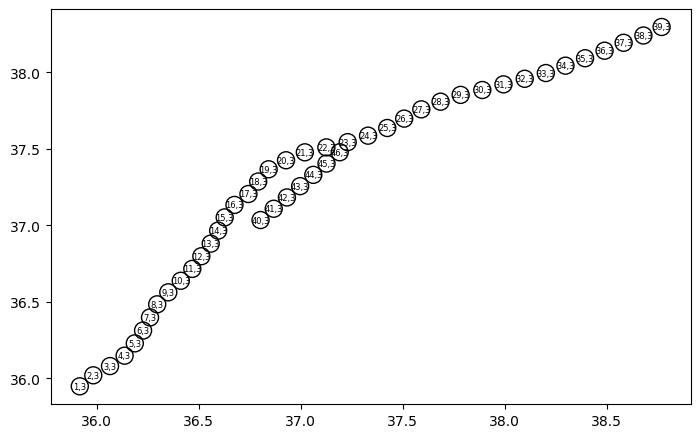

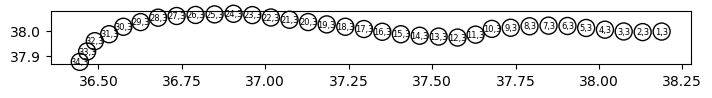

In [3]:
# non-planar model coodinates; distance from the reference point, measured `along` the non-planar model fault
for modelid in [modelid_initial,modelid_second]:
    col_names = ['k','l','lat','lon','dep','strike','dip','rake','xloc','yloc']
    df_knot = pd.read_table(os.path.join(datarootdir, modelid, 'const/knot.dat_in'), names=col_names, header=None,
                       delim_whitespace=True)

    fig = plt.figure()
    aspect=np.abs((np.max(df_knot['lon'])-np.min(df_knot['lon']))/(np.max(df_knot['lat'])-np.min(df_knot['lat'])))
    ax = fig.add_axes([0,0,1,1/aspect])

    tmpdf = df_knot[ df_knot['k']==3 ] # a source element at a layer (k = 3)
    ax.scatter(tmpdf['lon'],tmpdf['lat'],fc='none',ec='k',s=150,clip_on=False)
    for lon,lat,k,l in zip(tmpdf['lon'],tmpdf['lat'],tmpdf['k'],tmpdf['l']):
        text=str(l)+','+str(k)
        ax.text(lon,lat,text,ha='center',va='center',clip_on=False,size=6)
    plt.show()


-430.0 -30.0 -40.0 40.0 -15.0 15.0


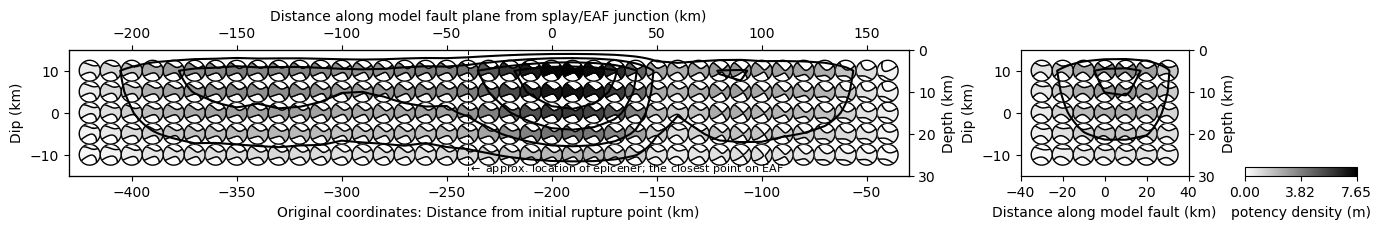

In [10]:
modelid = modelid_initial
model_para = load_fort40(os.path.join(datarootdir,modelid,'const','fort.40'))

# some important indexes of source elements
m1 = 39 # right end of main EAF
m2 = 23 # (near) junction of EAF and splay faults
x_for_m2 = (m2-model_para.m0[0])*model_para.xx[0] # location of junction on the original coordinates

# define axes edges; add margin ±10 km from the edge element
xmin_main=(1-model_para.m0[0])*model_para.xx[0]-model_para.xx[0]
xmax_main=(m1-model_para.m0[0])*model_para.xx[0]+model_para.xx[0]
xmin_branch=(m1+1-model_para.m0[0])*model_para.xx[0]-model_para.xx[0]
xmax_branch=(model_para.mn[0]-model_para.m0[0])*model_para.xx[0]+model_para.xx[0]
ymin=(1-model_para.n0[0])*model_para.yy[0]-model_para.yy[0]
ymax=(model_para.nn[0]-model_para.n0[0])*model_para.yy[0]+model_para.yy[0]
ymin_branch,ymax_branch=ymin,ymax
print(xmin_main,xmax_main,xmin_branch,xmax_branch,ymin,ymax)

fig=plt.figure(figsize=(5.6,5.6))

# main EAF axis
axx,axy=0.1,0.1
axw=1.5
aspect=abs(ymax-ymin)/abs(xmax_main-xmin_main)
axh=axw*aspect*2
ax1=fig.add_axes([axx,axy,axw,axh])
ax1.set(xlim=[xmin_main,xmax_main],ylim=[ymin,ymax],ylabel='Dip (km)',xlabel='Original coordinates: Distance from initial rupture point (km)')
# plot a line indicating the point on the EAF, which is the closest to the initial rupture point on the splay fault, regarded as an approximimate location of epicenter
ax1.axvline(x_for_m2-40,lw=0.75,linestyle='--',color='k',zorder=11)
ax1.text(x_for_m2-40,ymin,r'$\leftarrow$'+' approx. location of epicener; the closest point on EAF',ha='left',va='bottom',size=8)

# location of junction on the main EAF
x_for_m2 = (m2-model_para.m0[0])*model_para.xx[0]

# add psuedo axis, just shift the distance by measuring from the splay/EAF junction
ax = ax1.twiny()
ax.set(xlim=[xmin_main-x_for_m2,xmax_main-x_for_m2],xlabel='Distance along model fault plane from splay/EAF junction (km)')

# splay fault axis
axp=ax1.get_position()
axx,axy=axp.x1+0.2,axp.y0
axw=axw*(abs(xmax_branch-xmin_branch)/abs(xmax_main-xmin_main))
axh=axp.height
ax2=fig.add_axes([axx,axy,axw,axh])
ax2.set(xlim=[xmin_branch,xmax_branch],ylim=[ymin,ymax],xlabel='Distance along model fault (km)',ylabel='Dip (km)')

# add depth axis
for ax in [ax1,ax2]:
    ax_dep = ax.twinx()
    depmin = model_para.depth[0]-np.sin(np.deg2rad(model_para.dip[0]))*ymin
    depmax = model_para.depth[0]-np.sin(np.deg2rad(model_para.dip[0]))*ymax
    ax_dep.set(ylim=[depmin, depmax],ylabel='Depth (km)')
    
# beachballs
potency_density_file = os.path.join(datarootdir,modelid,'const','pdtdis.dat')
model_para = load_fort40(os.path.join(datarootdir,modelid,'const','fort.40'))
col_names = ['ylocs','xlocs','ys','xs','lat','lon','depth','slip','mrr','mtt','mpp','mrt','mrp','mtp']
df = pd.read_table(potency_density_file, names=col_names, header=None,
                   delim_whitespace=True, usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12,13))
df = df.sort_values('slip')
vmin, vmax = 0, max(df['slip'])
norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap=plt.get_cmap('gray_r')
levels = np.linspace(vmin, vmax, 6)[1:]

for ax,tmpdf,contour_file in zip([ax1,ax2],
                                 [df[df['xlocs']<=m1].copy(),df[df['xlocs']>m1].copy()],
                                 ['tmp_main.grd','tmp_branch.grd']):
    try:
        for j in range(len(tmpdf)):
            tmp = pmt.symmat6(
                tmpdf['mrr'].values[j],
                tmpdf['mtt'].values[j],
                tmpdf['mpp'].values[j],
                tmpdf['mrt'].values[j],
                tmpdf['mrp'].values[j],
                tmpdf['mtp'].values[j],
            )
            mt = pmt.MomentTensor(m_up_south_east=tmp)
            tmp = beachball.plot_beachball_mpl(mt, ax, size=15, position=(tmpdf['xs'].values[j], tmpdf['ys'].values[j]),
                                     beachball_type='deviatoric', edgecolor='k', color_t=cmap(norm(tmpdf['slip'].values[j])),
                                     color_p='w',linewidth=1)
    except AssertionError as e:
        print(e)

    # plot contour    
    fh = Dataset(os.path.join(datarootdir, modelid,'const', contour_file), mode='r')
    xs = fh.variables['x'][:]; ys = fh.variables['y'][:]; zs = fh.variables['z'][:]
    fh.close()
    ax.contour(xs,ys,zs,levels=levels,colors='k')


axp=ax2.get_position()
cax=fig.add_axes([axp.x1+0.1, axp.y0, 0.2, 0.015])
cb=mpl.colorbar.ColorbarBase(cax,cmap=cmap,norm=norm,orientation='horizontal',ticks=np.linspace(vmin,vmax,3),format='%.2f',label='potency density (m)')                                    
    
plt.show()

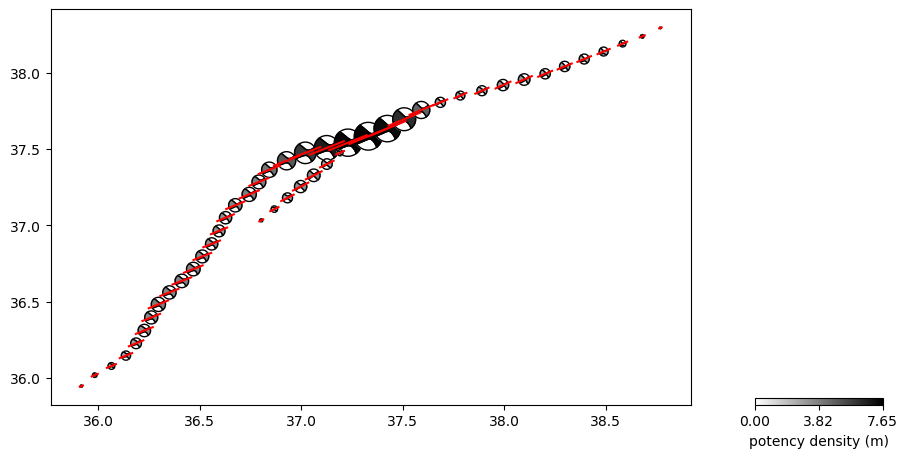

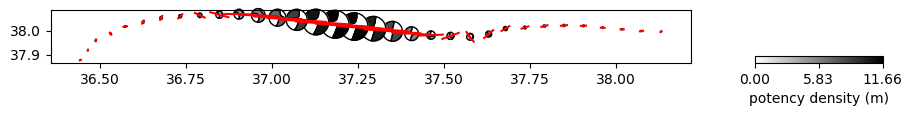

In [5]:
# CAUTION!! lon/lat coordinates are properly transformed in mercator projection using Cartopy in Figs. 2 and 3 in Okuwaki et al. (2023)
#           below example is JUST FOR A VERY EASY check of results
for modelid,ref_strike,ref_dip in zip([modelid_initial,modelid_second],[54,261],[90,90]):
    model_para = load_fort40(os.path.join(datarootdir, modelid, 'const/fort.40'))
    col_names = ['k','l','lat','lon','dep','strike','dip','rake','xloc','yloc']
    df_knot = pd.read_table(os.path.join(datarootdir, modelid, 'const/knot.dat_in'), names=col_names, header=None,
                       delim_whitespace=True)
    col_names = ['ylocs','xlocs','ys','xs','lat','lon','depth','slip','mrr','mtt','mpp','mrt','mrp','mtp','strike1','dip1','rake1']
    df_pdti = pd.read_table(os.path.join(datarootdir, modelid, 'const/pdtdis.dat'), names=col_names, header=None,
                       delim_whitespace=True, usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19))
    vmin, vmax = 0, np.max(df_pdti['slip'])
    norm=mpl.colors.Normalize(vmin=0, vmax=vmax)

    fig = plt.figure()
    aspect=np.abs((np.max(df_knot['lon'])-np.min(df_knot['lon']))/(np.max(df_knot['lat'])-np.min(df_knot['lat'])))
    ax = fig.add_axes([0,0,1,1/aspect])
    ax.scatter([],[])
    
    cmap=plt.get_cmap('gray_r')
    for l in range(model_para['mn'].values[0]):
        tmpdf = df_pdti[df_pdti['xlocs'] == l+1]
        tmpdf = tmpdf[tmpdf['slip'] == np.max(tmpdf['slip'])]
        j = 0
        if len(tmpdf) > 0:
            tmp = pmt.symmat6(
                tmpdf['mrr'].values[j],
                tmpdf['mtt'].values[j],
                tmpdf['mpp'].values[j],
                tmpdf['mrt'].values[j],
                tmpdf['mrp'].values[j],
                tmpdf['mtp'].values[j],
            )
            mt = pmt.MomentTensor(m_up_south_east=tmp)
            tmpdf_knot = df_knot[(df_knot['l'] == tmpdf['xlocs'].values[j]) & (df_knot['k'] == tmpdf['ylocs'].values[j])]
            x, y = tmpdf_knot['lon'].values[0], tmpdf_knot['lat'].values[0]
            tmp = beachball.plot_beachball_mpl(mt, ax, size=tmpdf['slip'].values[j]/vmax*20, position=(x,y),
                                     beachball_type='deviatoric', edgecolor='k', color_t=cmap(norm(tmpdf['slip'].values[j])),
                                     color_p='w', linewidth=1)
            tmp.set_clip_on(False)
            strike1,dip1,rake1 = mt.both_strike_dip_rake()[0]
            strike2,dip2,rake2 = mt.both_strike_dip_rake()[1]
            tmpstr, tmpdip, tmprake = selectplane(ref_strike,ref_dip,strike1,dip1,rake1,strike2,dip2,rake2)
            xs, ys = [], []
            for pm in [-1, 1]:
                tmp = geod.Direct(y, x, tmpstr, pm*tmpdf['slip'].values[j]/vmax*1e3*10)
                x1, y1 = tmp['lon2'], tmp['lat2']
                xs.append(x1)
                ys.append(y1)
            ax.plot(xs,ys,color='r')
        
    axp=ax.get_position()
    cax=fig.add_axes([axp.x1+0.1, axp.y0, 0.2, 0.015])
    cb=mpl.colorbar.ColorbarBase(cax,cmap=cmap,norm=norm,orientation='horizontal',ticks=np.linspace(vmin,vmax,3),format='%.2f',label='potency density (m)')                        
    plt.show()

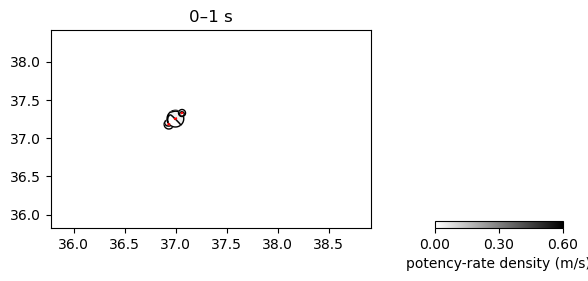

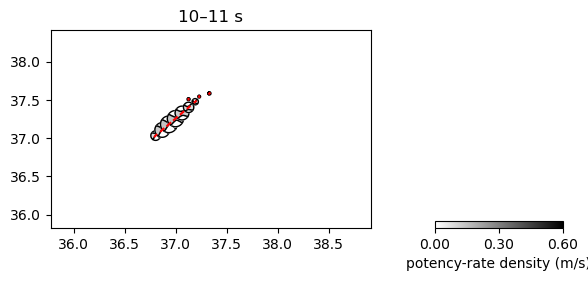

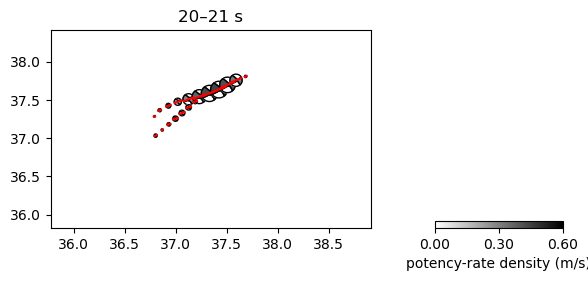

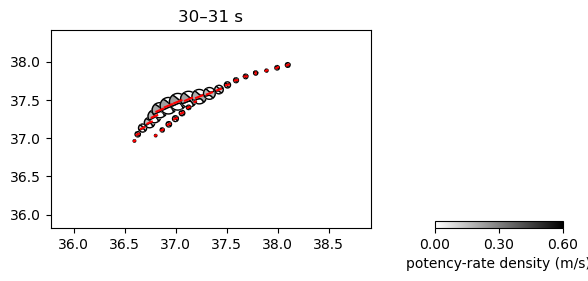

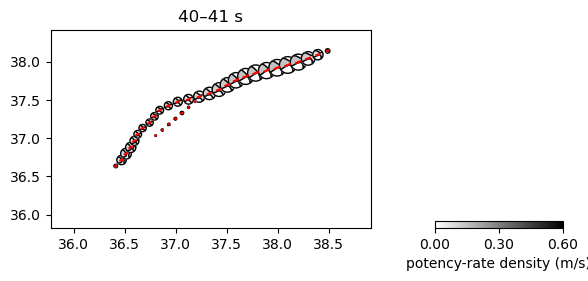

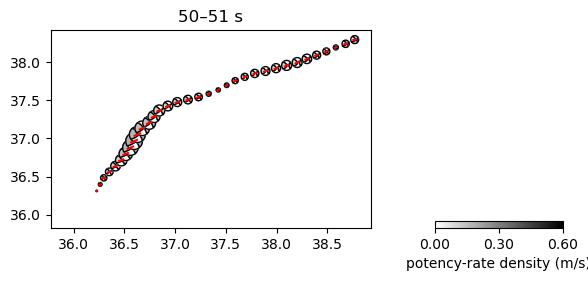

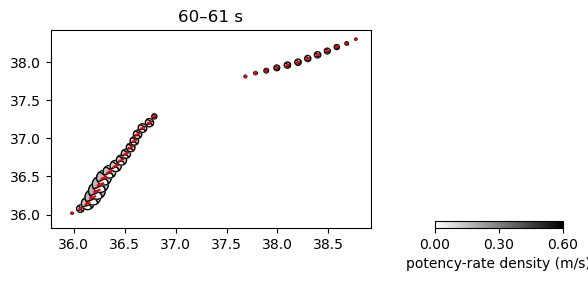

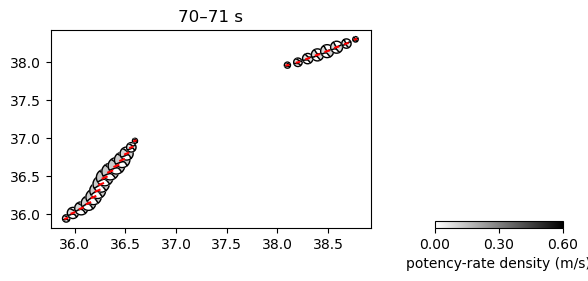

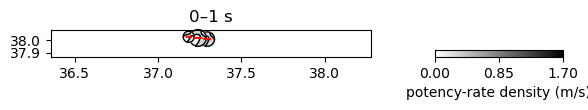

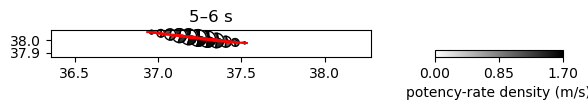

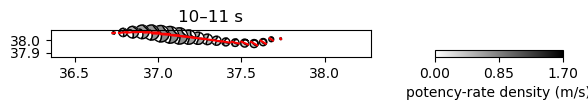

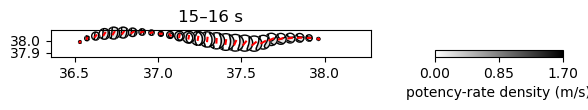

In [6]:
# CAUTION!! lon/lat coordinates are properly transformed in mercator projection using Cartopy in Figs. 2 and 3 in Okuwaki et al. (2023)
#           below example is JUST FOR A VERY EASY check of results
for modelid,ref_strike,ref_dip,frames in zip([modelid_initial,modelid_second],[54,261],[90,90],[np.arange(0,80,10),np.arange(0,20,5)]):

    model_para = load_fort40(os.path.join(datarootdir, modelid, 'const/fort.40'))
    col_names = ['k','l','lat','lon','dep','strike','dip','rake','xloc','yloc']
    df_knot = pd.read_table(os.path.join(datarootdir, modelid, 'const/knot.dat_in'), names=col_names, header=None,
                       delim_whitespace=True)

    snap_file = os.path.join(datarootdir,modelid,'const','snap_no_rotation.dat')
    col_names = ['ylocs','xlocs','tw','xs','ys','slip','mrr','mtt','mpp','mrt','mrp','mtp','lat','lon']
    df_snap = pd.read_table(snap_file, names=col_names, header=None, delim_whitespace=True,
                            usecols=(0,1,2,3,4,5,6,7,8,9,10,11,18,19))
    df_snap = df_snap.sort_values('slip')
    vmin, vmax = 0, np.max(df_snap['slip'])
    cmap = plt.get_cmap('gray_r')
    norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    for frame in frames:

        fig = plt.figure()
        aspect=np.abs((np.max(df_knot['lon'])-np.min(df_knot['lon']))/(np.max(df_knot['lat'])-np.min(df_knot['lat'])))
        ax = fig.add_axes([0,0,0.5,0.5/aspect])
        ax.scatter(df_knot['lon'],df_knot['lat'],alpha=0)

        tw = frame + 1
        ax.set_title(str(tw-1)+'–'+str(tw)+' s')
        tmpdf = df_snap[ df_snap['tw'] == tw ].reset_index()
        vmax_for_each_tw = np.max(tmpdf['slip'])
        for m in range(model_para['mn'].values[0]):
            m = m + 1
            m_tmpdf = tmpdf[ tmpdf['xlocs'] == m ]
            vmax_for_each_m = np.max(m_tmpdf['slip'])
            m_tmpdf = m_tmpdf[ m_tmpdf['slip'] == vmax_for_each_m ]
            if len(m_tmpdf) > 0:
                tmp = pmt.symmat6(
                    m_tmpdf['mrr'].values[0],
                    m_tmpdf['mtt'].values[0],
                    m_tmpdf['mpp'].values[0],
                    m_tmpdf['mrt'].values[0],
                    m_tmpdf['mrp'].values[0],
                    m_tmpdf['mtp'].values[0],
                )
                mt = pmt.MomentTensor(m_up_south_east=tmp)
                potency = m_tmpdf['slip'].values[0]
                xloc = m_tmpdf['xlocs'].values[0] # assume the model dip is 90 and hence the x and y loc are the same along dip direction
                yloc = m_tmpdf['ylocs'].values[0] # assume thet model dip is 90 and hence the x and y loc are the same along dip direction
                df_filter = (df_knot['l'] == xloc) & (df_knot['k'] == yloc)
                x, y = df_knot[df_filter]['lon'].values[0], df_knot[df_filter]['lat'].values[0]
                size = 12*potency/vmax_for_each_tw            
                tmp = beachball.plot_beachball_mpl(mt, ax, size=size, position=(x,y),
                                         beachball_type='deviatoric', edgecolor='k', color_t=cmap(norm(potency)),
                                         color_p='w', linewidth=1)
                tmp.set_clip_on(False)
                strike1,dip1,rake1 = mt.both_strike_dip_rake()[0]
                strike2,dip2,rake2 = mt.both_strike_dip_rake()[1]
                tmpstr, tmpdip, tmprake = selectplane(ref_strike,ref_dip,strike1,dip1,rake1,strike2,dip2,rake2)
                xs, ys = [], []
                for pm in [-1, 1]:
                    tmp = geod.Direct(y, x, tmpstr, pm*potency/vmax*1e3*10)
                    x1, y1 = tmp['lon2'], tmp['lat2']
                    xs.append(x1)
                    ys.append(y1)
                ax.plot(xs,ys,color='r')

        axp=ax.get_position()
        cax=fig.add_axes([axp.x1+0.1, axp.y0, 0.2, 0.015])
        cb=mpl.colorbar.ColorbarBase(cax,cmap=cmap,norm=norm,orientation='horizontal',ticks=np.linspace(vmin,vmax,3),format='%.2f',label='potency-rate density (m/s)')                                    
        plt.show()

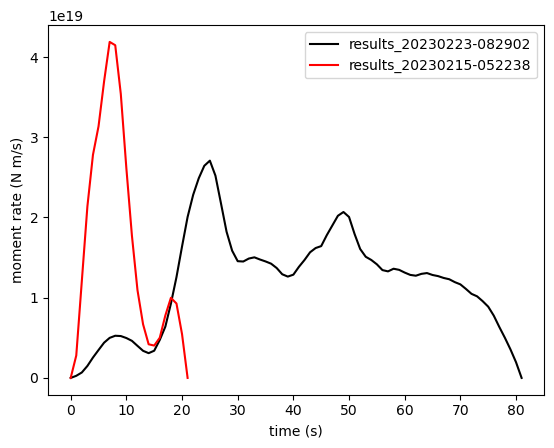

In [7]:
# moment rate function
for modelid,color in zip([modelid_initial,modelid_second],['k','r']):
    x,y=np.loadtxt(os.path.join(datarootdir,modelid,'const/mrf.dat'),usecols=(0,1),unpack=True)
    plt.plot(x,y*1e18,label=modelid,color=color)
plt.legend()
plt.ylabel('moment rate (N m/s)'); plt.xlabel('time (s)')
plt.show()

[0.1273 0.2546 0.3819 0.5092 0.6365] m/s


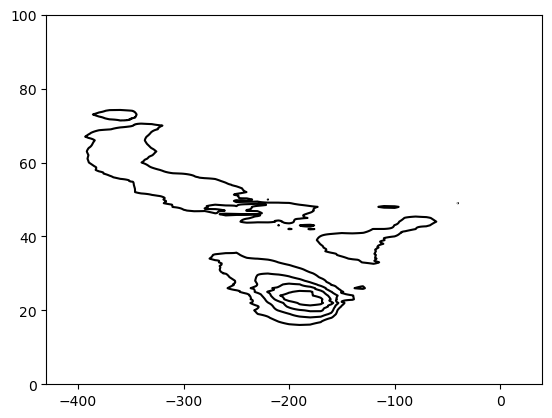

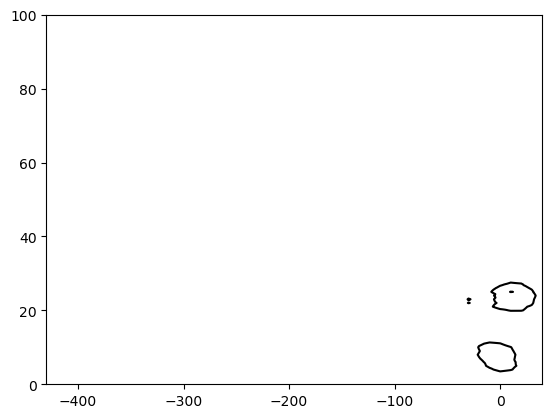

[0.35771999 0.71543999 1.07315998 1.43087997 1.78859997] m/s


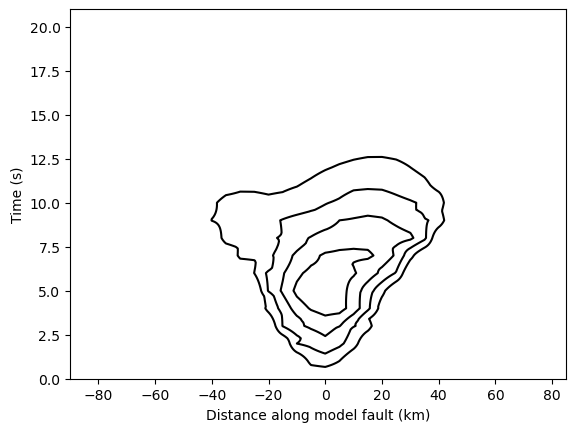

In [8]:
def load_grd(datarootdir,modelid,data):
    fh = Dataset(os.path.join(datarootdir,modelid,data),mode='r')
    xs = fh.variables['x'][:];ys = fh.variables['y'][:];zs = fh.variables['z'][:]
    fh.close()
    return xs,ys,zs

# lateral evolution of potency-rate density along model fault plane
modelid = modelid_initial

xs,ys,zs=load_grd(datarootdir,modelid,'const/tmp_vr_str_main.grd')
vmin,vmax=0,np.max(zs)
levels = np.linspace(vmin,vmax,6)[1:]
print(levels,'m/s')
plt.contour(xs,ys,zs,levels=levels,colors='k')
plt.show()

xs,ys,zs=load_grd(datarootdir,modelid,'const/tmp_vr_str_branch.grd')
plt.contour(xs,ys,zs,levels=levels,colors='k')
plt.show()

modelid = modelid_second

xs,ys,zs=load_grd(datarootdir,modelid,'const/tmp_vr_str.grd')
vmin,vmax=0,np.max(zs)
levels = np.linspace(vmin,vmax,6)[1:]
print(levels,'m/s')
plt.contour(xs,ys,zs,levels=levels,colors='k')
plt.xlabel('Distance along model fault (km)'); plt.ylabel('Time (s)')
plt.show()

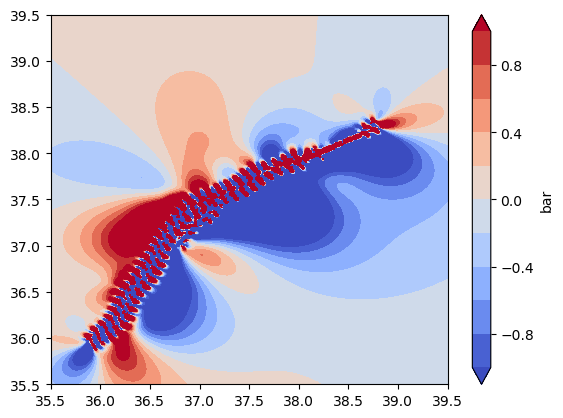

In [9]:
# Coulomb stress data
receirver_strike = 261
receirver_dip = 42
receirver_rake = -8

modelid = modelid_initial

dfs = []
for receiver_depth in np.arange(5.0, 35.0, 5.0):
    filename = os.path.join(datarootdir,'coulomb/coulomb_source_model_'+modelid+'_depth_'+\
                      str(receiver_depth)+'_strike_'+str(receirver_strike)+'_dip_'+str(receirver_dip)+'_rake_'+str(receirver_rake)+'.out')
    dfs.append(pd.read_csv(filename, delim_whitespace=True))
df = pd.concat(dfs).groupby(['lon.','lat.'], as_index=False)['coulomb_stress(bar)'].mean()
x, y, z = df['lon.'], df['lat.'], df['coulomb_stress(bar)']
xs=np.linspace(min(x), max(x), 1000)
ys=np.linspace(min(y), max(y), 1000)
X, Y = np.meshgrid(xs, ys)
Z = griddata((x, y), z, (X, Y),'linear')
vmin, vmax = -1, 1
levels = np.linspace(vmin, vmax, 11)
sc=plt.contourf(X,Y,Z,levels=levels,cmap='coolwarm',extend='both')
plt.colorbar(sc,label='bar')
plt.show()